In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install --upgrade pandas
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow_decision_forests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow_decision_forests.keras import pd_dataframe_to_tf_dataset
from tensorflow_decision_forests.keras import Task
from tensorflow_decision_forests.keras import RandomForestModel
from tensorflow_decision_forests.keras.core import YggdrasilTrainingConfig
from tensorflow_decision_forests.keras import AdvancedArguments
from yggdrasil_decision_forests.learner.random_forest import random_forest_pb2
from yggdrasil_decision_forests.learner.decision_tree import decision_tree_pb2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2
import time

In [5]:
#Reading data
path = '/content/drive/MyDrive/yourfolder'
csv = 'ames.csv'
df = pd.read_csv(path+csv,  low_memory=False)
df.drop(['Order', 'PID'], axis=1, inplace=True)
df.rename({col: col.replace('.', '_') for col in df.columns}, 
          axis=1, inplace=True)
df.sort_values(by=['Yr_Sold', 'Mo_Sold'], 
               axis=0, 
               ignore_index=True, 
               inplace=True)

In [6]:
#Create Dt column
df['Dt_Sold'] = pd.to_datetime([str(i[0])+'/'+str(i[1])+'/1'
                                for i in df[['Yr_Sold', 'Mo_Sold']].values])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


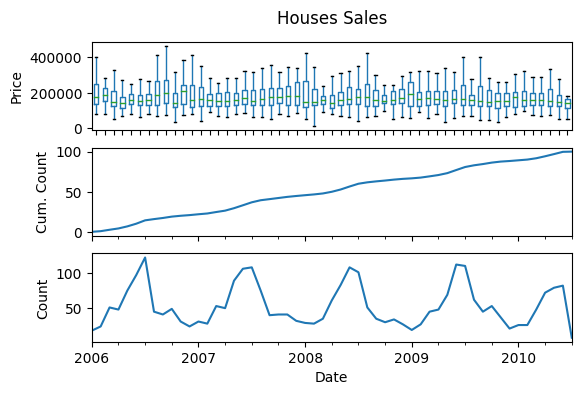

In [7]:
#Analyzing the problem like a TSA 
fig, (ax3, ax2, ax1) = plt.subplots(3, dpi=100)
ax1_df = df['Dt_Sold'].value_counts().sort_index()
ax1_df.plot.line(ax=ax1)
ax1.set_ylabel('Count')
ax1.set_xlabel('Date')

ax2_df = (ax1_df.cumsum()/ax1_df.sum())*100
ax2_df.plot.line(ax=ax2)
ax2.set_ylabel('Cum. Count')
ax2.set_xticklabels(['' for i in ax1.get_xticklabels()])

df.boxplot(column=['SalePrice'],
           by=['Dt_Sold'],
           showfliers=False,
           ax=ax3,
           grid=False)
ax3.set_ylabel('Price')
ax3.set_xticklabels(['' for i in ax1.get_xticklabels()])
ax3.set_xlabel('')
ax3.get_figure().suptitle('')
ax3.set_title('')
fig.suptitle('Houses Sales')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:1089: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


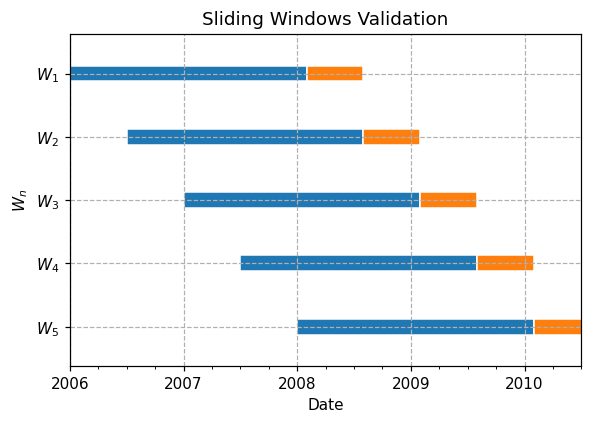

In [8]:
#Sliding Time Windows Validation
fig, ax = plt.subplots(dpi=110)
ax2_df.plot.line(ax=ax, c='w', alpha=0)
time = [str(dt)[:10] for dt in df['Dt_Sold'].unique()]
windows = []
y = -2.5
base = 25
interval = 6
for i in range(base, len(time), interval):
    if i == base:
        window = time[:base]+time[i:i+interval]
    else:
        window = windows[-1][interval:]+time[i:i+interval]
    windows.append(window)
    a1 = window[0]
    b1 = len(window)-interval
    a2 = window[b1]
    b2 = interval
    ax.broken_barh([(a1, b1), (a2, b2)], (y, 5), 
                    ec='w', facecolors=('tab:blue', 'tab:orange'))
    y += 20
ax.set_ylim(92.5, -12.5)
ax.set_xlabel('Date')
ax.set_ylabel('$W_{n}$')
ax.set_yticklabels([f'$W_{i+1}$' for i in range(-1, len(windows))])
plt.title('Sliding Windows Validation')
plt.grid(ls='--')
plt.show()

In [9]:
#Bechmark models
models = {}

models['Random Forest'] = RandomForestModel(task=Task.REGRESSION)

config = YggdrasilTrainingConfig()
rf_config = config.Extensions[random_forest_pb2.random_forest_config]
rf_config.decision_tree.sparse_oblique_split.binary_weight = False
models['Oblique Random Forest'] = RandomForestModel(task=Task.REGRESSION,
                                                    split_axis='SPARSE_OBLIQUE',
                                                    advanced_arguments=AdvancedArguments(
                                                        yggdrasil_training_config=config))

config = YggdrasilTrainingConfig()
rf_config = config.Extensions[random_forest_pb2.random_forest_config]
rf_config.bootstrap_training_dataset = False
rf_config.decision_tree.numerical_split.type = decision_tree_pb2.NumericalSplit.HISTOGRAM_RANDOM
models['Extremely Randomized Trees'] = RandomForestModel(task=Task.REGRESSION,
                                                         advanced_arguments=AdvancedArguments(
                                                             yggdrasil_training_config=config))


Use /tmp/tmplg0t6__k as temporary training directory
Use /tmp/tmpp2lnmtmo as temporary training directory
Use /tmp/tmp176mw2ex as temporary training directory


In [10]:
#Function to run all models
def train_and_predict_tfdf(model, name, train_df, test_df, w_i):

    train_ds = pd_dataframe_to_tf_dataset(train_df.drop('Dt_Sold', axis=1), 
                                      label='SalePrice',
                                      task=Task.REGRESSION)
    
    test_ds = pd_dataframe_to_tf_dataset(test_df.drop('Dt_Sold', axis=1), 
                                      label='SalePrice',
                                      task=Task.REGRESSION)
    
    y_true = test_df['SalePrice'].values

    start_train = time.time()
    model.fit(train_ds, verbose=0)
    train_time = time.time()-start_train

    y_pred = model.predict(test_ds)

    scores = [name, w_i, test_df.shape[0], train_time, 
              mse(y_true, y_pred, squared=False),
              mse(y_true, y_pred),
              mae(y_true, y_pred),
              mape(y_true, y_pred),
              r2(y_true, y_pred)]
    return scores

In [ ]:
#Benchmark Experiment
benchmark = []

for w_i, window in enumerate(windows):
    
    n = len(window)-interval
    train_df = df[df['Dt_Sold'].isin(window[:n])]
    test_df = df[df['Dt_Sold'].isin(window[n:])]
    
    for model in models:
        benchmark.append(train_and_predict_tfdf(model=models[model],
                                                name=model,
                                                train_df=train_df,
                                                test_df=test_df,
                                                w_i=w_i))
        print(benchmark[-1])


benchmark_df = pd.DataFrame(benchmark,
                            columns=['model','w_i','test_size', 'train_time',
                                     'mse','rmse','mae','mape','r2'])

In [46]:
#MSE Analysis
benchmark_df.groupby('model')['mse'].describe()[['min', 'mean', 'std']].round()

,min,mean,std
model,,,
Extremely Randomized Trees,24079.0,25677.0,1219.0
Oblique Random Forest,21575.0,23345.0,1628.0
Random Forest,21581.0,23889.0,1911.0


In [47]:
#RMSE Analisys
benchmark_df.groupby('model')['rmse'].describe()[['min', 'mean', 'std']].round()

,min,mean,std
model,,,
Extremely Randomized Trees,579795209.0,660489574.0,62862421.0
Oblique Random Forest,465479253.0,547097032.0,76744322.0
Random Forest,465756045.0,573628946.0,91709535.0


In [48]:
#MAE Analisys
benchmark_df.groupby('model')['mae'].describe()[['min', 'mean', 'std']].round()

,min,mean,std
model,,,
Extremely Randomized Trees,15945.0,16669.0,527.0
Oblique Random Forest,13962.0,15196.0,1089.0
Random Forest,14003.0,15551.0,1282.0


In [54]:
#MAPE Analisys
benchmark_df.groupby('model')['mape'].describe()[['min', 
                                                  'mean', 
                                                  'std']].round(3)

,min,mean,std
model,,,
Extremely Randomized Trees,0.101,0.109,0.005
Oblique Random Forest,0.092,0.101,0.007
Random Forest,0.096,0.103,0.006


In [55]:
#R2 Analisys
benchmark_df.groupby('model')['r2'].describe()[['min', 'mean', 'std']].round(3)

,min,mean,std
model,,,
Extremely Randomized Trees,0.857,0.887,0.020
Oblique Random Forest,0.893,0.907,0.011
Random Forest,0.885,0.903,0.012


In [56]:
#Run Time Analisys
benchmark_df.groupby('model')['train_time'].describe()[['min', 
                                                        'mean', 
                                                        'std']].round()

,min,mean,std
model,,,
Extremely Randomized Trees,3.0,3.0,0.0
Oblique Random Forest,113.0,128.0,14.0
Random Forest,3.0,5.0,3.0


In [165]:
#Selected Model Analisys
model = RandomForestModel(task=Task.REGRESSION,
                          compute_oob_variable_importances=True)

train_df = df[df['Dt_Sold'].isin(time[:base])]
test_df = df[df['Dt_Sold'].isin(time[base:])]

train_ds = pd_dataframe_to_tf_dataset(train_df.drop('Dt_Sold', axis=1), 
                                      label='SalePrice',
                                      task=Task.REGRESSION)    
test_ds = pd_dataframe_to_tf_dataset(test_df.drop('Dt_Sold', axis=1), 
                                     label='SalePrice',
                                    task=Task.REGRESSION)

model.fit(train_ds, verbose=0)
inspector = model.make_inspector()

Use /tmp/tmpysn0gx84 as temporary training directory


/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [166]:
#Validation Analisys
valid_df = test_df.join(pd.DataFrame(model.predict(test_ds),
                                     columns=['PredSalePrice'],
                                     index=test_df['SalePrice'].index))

In [171]:
#Error Analisys
valid_df['SalePriceError'] = valid_df['SalePrice']-valid_df['PredSalePrice']
fig, ax = plt.subplots(1, dpi=100)
valid_df.plot.hexbin(y='SalePrice',
                     x='PredSalePrice',
                     C='SalePriceError',
                     cmap='seismic', 
                     gridsize=100,
                     ax=ax)
ax.set_facecolor('whitesmoke')
fig.show()